In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import os

#For editable text. Except latex text is still shapes
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

#Set style
sns.set(style = "whitegrid", palette="pastel", color_codes=True)

# for skv: locally -- /figures/fig2/04112021_sigInGTEX_allTiss.ipynb

In [2]:
figEnd = "_05102021.pdf"

In [3]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [4]:
sig = pd.read_csv("../signatures_git/cellTypeSigs_inGTEx_04112021.csv", sep = ",", index_col = 0)
sig.columns = [i.split("-")[0] for i in sig.columns]

gtexTiss = np.unique(sig.index.tolist())

In [5]:
sig[sig.index == "Kidney - Cortex"].shape + sig[sig.index == "Kidney - Medulla"].shape

(85, 27, 4, 27)

In [6]:
parentTiss = {}
parentTiss['Brain'] = ['Ast', 'Ex', 'In',  'Oli', 'Opc'] # removed 'Mic'

parentTiss["Placenta"] = ["EVT", "SCT"]

parentTiss["Kidney"] = ['Proximal tubule']
                       #['Podocyte', ]

parentTiss["Liver"] = ['Hepatocytes']



parentTiss["Heart"] = ["Atrial_Cardiomyocyte", "Ventricular_Cardiomyocyte"]

In [7]:
parentTiss

{'Brain': ['Ast', 'Ex', 'In', 'Oli', 'Opc'],
 'Placenta': ['EVT', 'SCT'],
 'Kidney': ['Proximal tubule'],
 'Liver': ['Hepatocytes'],
 'Heart': ['Atrial_Cardiomyocyte', 'Ventricular_Cardiomyocyte']}

Mathys samples came from the prefrontal cortex. so my plan now is just to use that and compare to NOT brain tissues in GTEx

that one is called 'Brain - Frontal Cortex (BA9)' in GTEx data

In [8]:
prefrontCortex = 'Brain - Frontal Cortex (BA9)'

In [9]:
heart_pal = {"Atrial Cardiomyocyte":"#004E98",
                 "Ventricular Cardiomyocyte":"#52D1DC"}

placenta_pal = {"Extravillous Trophoblast": "#39A0ED",
    "Syncytiotrophoblast": "#F0BCD4"}

kidney_pal = {}
kidney_pal["Proximal tubule"] = "#62b6cb"

liver_pal = {'Hepatocytes': '#893168'}

brain_pal = {'Astrocyte': '#96C9DC',
 'Excitatory Neuron': '#fb5607',
 'Inhibitory Neuron': '#ff006e',
 'Oligodendrocyte': '#8338ec',
 'Oligodendrocyte Precursor Cell': '#3a86ff'}

sns.color_palette(list(placenta_pal.values()))

[(0.2235294117647059, 0.6274509803921569, 0.9294117647058824),
 (0.9411764705882353, 0.7372549019607844, 0.8313725490196079)]

In [22]:
df = pd.DataFrame()
fname_ed6 = "/Users/kayaneh/Documents/deconvolution/aip/cfrna_nbt_submission/extendedData6_brainLiver.xlsx"
df.to_excel(fname_ed6)

df = pd.DataFrame()
fname_ed8 = "/Users/kayaneh/Documents/deconvolution/aip/cfrna_nbt_submission/extendedData8_kidneyPlacenta.xlsx"
df.to_excel(fname_ed8)

In [39]:
def plotLFCThisTiss(cell_pal, relCells, parentT, fullNames):
    
    allDF = pd.DataFrame()
    parentTissOnly = pd.DataFrame()
    notParentTissDF = pd.DataFrame()
    
    # first, go through the relevant cell types and get their aggregatae expression
    for cell in relCells:
        cellDF = pd.DataFrame(columns = ["index", "score"])
        relTiss = [i for i in gtexTiss if parentT in i]

        thisCell = sig[cell].loc[relTiss].to_frame().reset_index()
   
        thisCell["index"] = [i + "-" + cell for i in thisCell["index"]]
        thisCell["index"] = cell + "-" + parentT
        
        rest = sig[cell].loc[np.setdiff1d(gtexTiss, relTiss)].to_frame().reset_index()

        rest["index"] = ["NOT " + cell] * rest.shape[0]
        allTogether = pd.concat([thisCell, rest], axis = 0)
        allTogether.columns = ["index", "score"]
        cellDF = pd.concat([cellDF, allTogether])
        
        thisCell.columns = ["index", "score"]
        rest.columns = ["index", "score"]
        
        parentTissOnly = pd.concat([parentTissOnly, thisCell], axis = 0)
        notParentTissDF = pd.concat([notParentTissDF, rest], axis = 0)
        
        allDF = pd.concat([allDF, cellDF], axis = 0)
    
   
    # get the averages of the not GTEx tissues
    cols = ["celltype", "score"]
    averages = pd.DataFrame(columns = cols)
    for i in np.unique(notParentTissDF["index"]):
        thisCellAvg = notParentTissDF[notParentTissDF["index"] == i]["score"].mean()
        notTissAvgDF = pd.DataFrame([[i, thisCellAvg]], columns = cols )
        averages = averages.append(notTissAvgDF)
    
    
    
    
    
    # fix abbreviations of cell type naming
    if parentT == "Placenta":
        abbreviations = ["EVT", "SCT"]  
        fullNames = {}
        fullNames['Extravillous Trophoblast'] = "EVT"
        fullNames['Syncytiotrophoblast'] = "SCT"
   

    parentTissOnly["index"] = [fullNames[i] for i in parentTissOnly["index"]]
        
    
    print("parentTissOnly.shape ", parentTissOnly.shape)
    
    # now compute log fold changes
    lfcDF = pd.DataFrame(columns = ["score", "celltype"])
    if parentT != "Placenta":
        for i, cell in enumerate(np.unique(parentTissOnly["index"])):
            relSamps = (parentTissOnly[parentTissOnly["index"] == cell]["score"] - averages.iloc[i]["score"]).to_frame()
            relSamps["celltype"] = cell
            lfcDF = lfcDF.append(relSamps)
        print("LFC DF ", lfcDF.groupby(["celltype"]).mean())
        print('lfcDF.shape: ', lfcDF.shape)
        plt.figure(figsize = (6, 6)) 
            
        sns.boxplot(data = lfcDF, x = "celltype", y = "score", palette = cell_pal)
        #sns.swarmplot(data = lfcDF, x = "celltype", y = "score", 
        #             color = "0.25", size = 4)
        plt.ylabel("Log Fold Change Intensity in " + parentT + "Tissue")
        plt.xlabel("")
        plt.xticks(rotation = "90")
        plt.title("LFC plot")
        #save_figure_pdf(plt, figSavePath + parentT + "_LFC_inGTEX" + figEnd)
        print(np.unique(lfcDF['celltype'], return_counts = True))
        if parentT == "Liver" or parentT == "Brain":
            with pd.ExcelWriter(fname_ed6, mode = 'a') as writer:
                lfcDF.to_excel(writer, sheet_name = parentT, engine = 'xlsxwriter')
        if parentT == "Kidney":
            with pd.ExcelWriter(fname_ed8, mode = 'a') as writer:
                lfcDF.to_excel(writer, sheet_name = parentT, engine = 'xlsxwriter')
            
    # since placenta is not in GTEx, just plot the sum of expression of the profile
    # in all the other tissues and show that it's true
    else:
        placenta_pal = {"NOT EVT": "#39A0ED", "NOT SCT": "#F0BCD4"}
        plt.figure(figsize = (6, 6)) 
        print('notParentTissDF.shape ', notParentTissDF.shape)
        sns.boxplot(data = notParentTissDF,
                    x = "index", y = "score", palette = placenta_pal)
        plt.ylabel("Intensity in non-" + parentT + "al Tissues")
        plt.xlabel("")
        plt.title("Aggregate Sum of Log CPM Intensity of Placental Cell Type Profiles")
        #save_figure_pdf(plt, figSavePath + "placenta_inGTEX" + figEnd)
        
        if parentT == "Placenta":
            with pd.ExcelWriter(fname_ed8, mode = 'a') as writer:
                notParentTissDF.to_excel(writer, sheet_name = parentT, engine = 'xlsxwriter')
        

In [40]:
kidney_fullNames = {}
#kidney_fullNames['Podocyte-Kidney'] = 'Podocyte'
kidney_fullNames['Proximal tubule-Kidney'] = 'Proximal tubule'

parentTissOnly.shape  (89, 2)
LFC DF                       score
celltype                  
Proximal tubule  33.902952
lfcDF.shape:  (89, 2)
(array(['Proximal tubule'], dtype=object), array([89]))


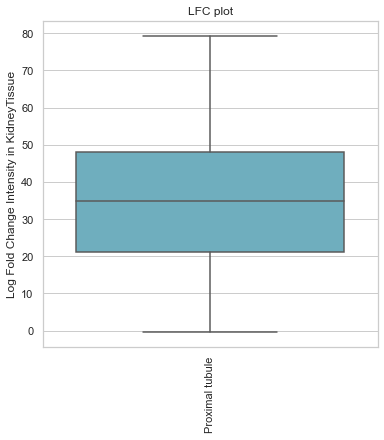

In [41]:
plotLFCThisTiss(kidney_pal, parentTiss["Kidney"], "Kidney", kidney_fullNames)

In [42]:
brain_fullNames = {}
brain_fullNames['Ast-Brain'] = "Astrocyte" 
brain_fullNames['Ex-Brain'] = 'Excitatory Neuron' 
brain_fullNames['In-Brain'] = 'Inhibitory Neuron' 
brain_fullNames['Oli-Brain'] = 'Oligodendrocyte'
brain_fullNames['Opc-Brain'] = "Oligodendrocyte Precursor Cell"

parentTissOnly.shape  (13210, 2)
LFC DF                                      score
celltype                                 
Astrocyte                       14.270473
Excitatory Neuron               37.432684
Inhibitory Neuron                1.991689
Oligodendrocyte                 19.993927
Oligodendrocyte Precursor Cell   6.129218
lfcDF.shape:  (13210, 2)
(array(['Astrocyte', 'Excitatory Neuron', 'Inhibitory Neuron',
       'Oligodendrocyte', 'Oligodendrocyte Precursor Cell'], dtype=object), array([2642, 2642, 2642, 2642, 2642]))


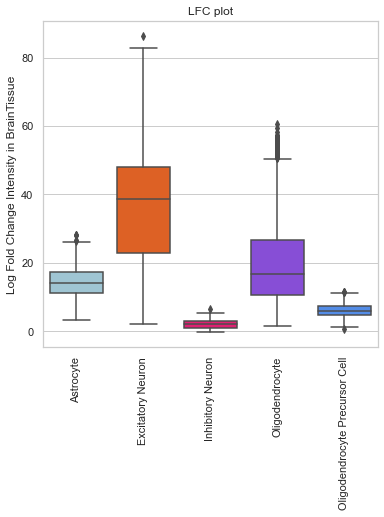

In [43]:
plotLFCThisTiss(brain_pal, parentTiss["Brain"], "Brain", brain_fullNames)

parentTissOnly.shape  (0, 2)
notParentTissDF.shape  (34764, 2)


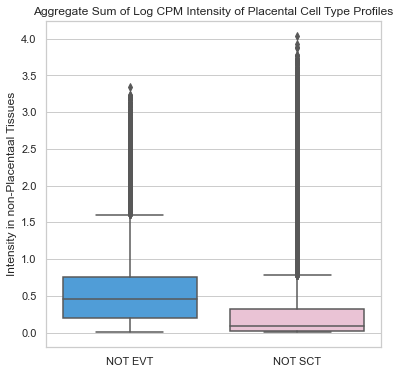

In [32]:
plotLFCThisTiss(placenta_pal, parentTiss["Placenta"], "Placenta", {})

In [29]:
liver_fullNames = {}
liver_fullNames["Hepatocytes-Liver"] = "Hepatocytes"

parentTissOnly.shape  (226, 2)
LFC DF                    score
celltype               
Hepatocytes  202.635421
lfcDF.shape:  (226, 2)


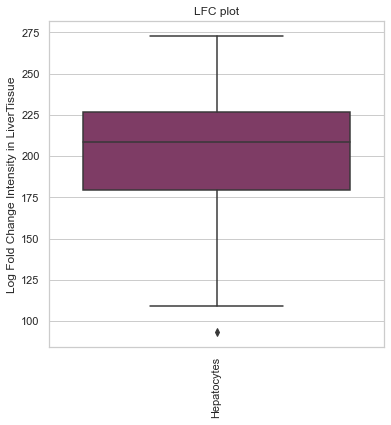

In [30]:
plotLFCThisTiss(liver_pal, parentTiss["Liver"], "Liver", liver_fullNames)

In [52]:
heart_fullNames = {}
heart_fullNames['Atrial_Cardiomyocyte-Heart'] = 'Atrial Cardiomyocyte'
heart_fullNames['Ventricular_Cardiomyocyte-Heart'] = "Ventricular Cardiomyocyte"

In [53]:
sig.loc[[i for i in gtexTiss if "Heart" not in i]]["Atrial_Cardiomyocyte"].mean()

0.21523314923713457

parentTissOnly.shape  (1722, 2)
LFC DF                                score
celltype                           
Atrial Cardiomyocyte       7.431001
Ventricular Cardiomyocyte  4.533369
lfcDF.shape:  (1722, 2)


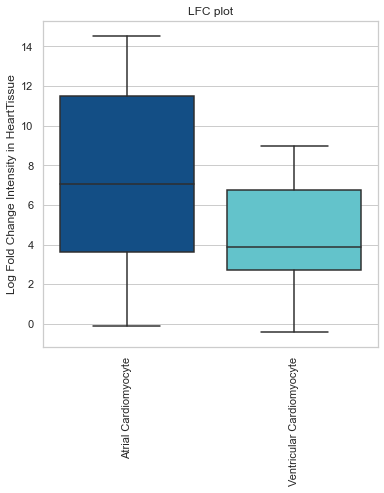

In [54]:
plotLFCThisTiss(heart_pal, parentTiss["Heart"], "Heart", heart_fullNames)

In [55]:
clear all